# Climate Protection versus Economic Convergence?

Author: Yvan Lengwiler

Date: 2021-10-19. This file: 2021-12-16

Paper available at https://doi.org/10.5451/unibas-ep85420

## 1 Preamble

In [1]:
import pandas as pd
import numpy as np
from numpy import log
import requests
# import urllib.request
import json
import statsmodels.api as sm
import scipy.stats as stats
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## 2 Download and Consolidate Data

In [2]:
year0 = 1975
year1 = 2018
Dt    = year1 - year0

### 2.1 Penn World Table, Version 10.0

In [3]:
url = 'https://www.rug.nl/ggdc/docs/pwt100.xlsx'
pwt_data = pd.read_excel(url,'Data')

In [4]:
pwt_data.rename(columns={'countrycode':'iso', 'csh_i':'sk', 'pop':'L', 'rgdpna':'Y'}, inplace=True)
pwt_data = pwt_data.filter(items=['iso','country','year','L','Y','sk'])

idx = (pwt_data['year']>=year0) & (pwt_data['year']<=year1)
# sk = pwt_data.loc[idx,['iso','sk']].groupby('iso').mean()
sk = pwt_data[idx].groupby('iso').agg({'sk': 'mean'})

idx = (pwt_data['year'] == year0)
pwt0 = pwt_data.loc[idx,['iso','country','L','Y']].set_index('iso')
pwt0.rename(columns={'L':'L0', 'Y':'Y0'}, inplace=True)

idx = (pwt_data['year'] == year1)
pwt1 = pwt_data.loc[idx,['iso','L','Y']].set_index('iso')
pwt1.rename(columns={'L':'L1', 'Y':'Y1'}, inplace=True)

### 2.2 Cohen-Soto-Leker data on educational attainment

In [5]:
# The following produces a certificate error for some reason ...
# url = 'https://www.parisschoolofeconomics.eu/docs/cohen-daniel/csl-database.xls'
# csl_data = pd.read_excel(url)
# ... so we have to do this a bit more indirectly ...
website = 'https://www.parisschoolofeconomics.eu/docs/cohen-daniel/'
fn = 'csl-database.xls'
url = (website + fn)
response = requests.get(url)
# response = urllib.request(url)
with open(fn, 'wb') as f:
    f.write(response.content)
csl_data = pd.read_excel(fn)

In [6]:
csl_data.rename(columns={'code':'iso'}, inplace=True)
idx = (csl_data['agefrom']==25) & (csl_data['ageto']==64)
csl = csl_data.loc[idx,:].set_index('iso')
csl = csl.assign(
    edu = (csl['edu_1970'] + csl['edu_1980'] + csl['edu_1990'] +
           csl['edu_2000'] + csl['edu_2000']) / 5
)
csl = csl.filter(items=['edu'])

### 2.3 Potsdam Institute for Climate Impact Research

In [7]:
url = ''.join((
    'https://www.climatewatchdata.org/api/v1/data/historical_emissions',
    '?start_year=', str(year0),
    '&end_year=', str(year1),
    '&gas_ids[]=330',
    '&source_ids[]=112',
    '&sector_ids[]=1313',
    '&per_page=1000&page=1'
))
response = requests.get(url)
with response as url:
    pik_json = json.loads(url.content)    
# response = urllib.request.urlopen(url)
# with response as url:
#    pik_json = json.loads(url.read().decode())

In [8]:
pik = pd.DataFrame()
for r in range(len(pik_json.get('data'))):
    emissions = pd.DataFrame(pik_json.get('data')[r]['emissions']).set_index('year')
    add = pd.DataFrame({
        'iso':pik_json.get('data')[r]['iso_code3'],
        'C0' :emissions.loc[year0],
        'C1' :emissions.loc[year1]
    })
    pik = pik.append(add)
pik = pik.set_index('iso')

### 2.4 Consolidate

In [9]:
idx = (pik['C0']==0) | (pik['C1']==0)
print(pik[idx].index.values)
# ATA (Antarctica), NIU (Niue), and TKL (Tokelau) have zero emissions, which produces
# an error when taking logs. These countries have no data in PWT and CSL, so they will
# be removed later anyway. We remove them here already to avoid the log(0) warning later.
pik = pik[~idx]

['ATA' 'NIU' 'TKL']


In [10]:
dat = pwt0
dat.Y0 = log(pwt0['Y0'])
dat.L0 = log(pwt0['L0'])
dat = dat.join(log(pwt1), how='outer')
dat = dat.join(log(pik) , how='outer')
dat = dat.assign(ypc0 = dat.Y0-dat.L0)
dat = dat.assign(ypc1 = dat.Y1-dat.L1)
dat = dat.join(sk       , how='outer')
dat = dat.join(csl      , how='outer')
dat = dat.assign(gy   = (dat.ypc1-dat.ypc0)/Dt )
dat = dat.assign(n    = (dat.L1  -dat.L0  )/Dt )
dat = dat.assign(p    = (dat.C1  -dat.C0  )/Dt )

In [11]:
# drop missing values
dat = dat.dropna()

# drop small countries (pop < 2m in 1975)
idx = (np.exp(dat.L0) >= 2.0)
dat = dat[idx]

# drop Venezuela (extreme outlier)
idx = (dat.index.values != 'VEN')
dat = dat[idx]

In [12]:
dat = dat.sort_values('ypc0', ascending=False)
smplAll  = range(len(dat.index))
smplRich = range(42)
smplPoor = range(42,len(dat.index))
smpl = (smplAll, smplRich, smplPoor)
nsmpl = len(smpl)

print('richer sample\n\n'  ,dat.iloc[smplRich]['country'])
print('\npoorer sample\n\n',dat.iloc[smplPoor]['country'])

richer sample

 iso
CHE                   Switzerland
NOR                        Norway
USA                 United States
NLD                   Netherlands
CAN                        Canada
SWE                        Sweden
DNK                       Denmark
AUS                     Australia
AUT                       Austria
DEU                       Germany
FRA                        France
ITA                         Italy
NZL                   New Zealand
BEL                       Belgium
GBR                United Kingdom
FIN                       Finland
ESP                         Spain
GRC                        Greece
IRL                       Ireland
JPN                         Japan
ARG                     Argentina
IRN    Iran (Islamic Republic of)
SGP                     Singapore
PRT                      Portugal
HUN                       Hungary
MEX                        Mexico
ZAF                  South Africa
BRA                        Brazil
TUR                        T

## 3 Regressions

In [13]:
headers = ['all countries', 't-value', 'richer countries', 't-value', 'poorer countries', 't-value']
rows    = ['const', 'p', 'n', 'R2 / R2 adj', '# obs']
results = [[''] * nsmpl*2 for _ in range(5)]

for s in range(nsmpl):
    thisdat = dat.iloc[smpl[s]]
    endo = thisdat.gy
    exo  = thisdat[['p','n']]
    exo  = sm.add_constant(exo)
    nexo = exo.shape[1]
    est  = sm.OLS(endo, exo).fit()
    for c in range(nexo):
        results[c][2*s]   = "{:.4f}".format(est.params[c])
        results[c][2*s+1] = "{:.4f}".format(est.tvalues[c])
    results[nexo][2*s]   = "{:.3f}".format(est.rsquared)
    results[nexo][2*s+1] = "{:.3f}".format(est.rsquared_adj)
    results[nexo+1][2*s] = str(int(est.nobs))

print('equation (5), unrestricted')
pd.DataFrame(results,rows,headers)

equation (5), unrestricted


,all countries,t-value,richer countries,t-value,poorer countries,t-value
const,0.0233,10.3119,0.0209,9.0196,0.0310,3.8610
p,0.6906,7.5568,0.3660,2.4163,0.6809,4.3279
n,-1.1384,-7.4170,-0.8576,-3.5455,-1.3718,-5.1861
R2 / R2 adj,0.462,0.448,0.252,0.214,0.585,0.562
# obs,82,,42,,40,


In [14]:
headers = ['all countries', 't-value', 'richer countries', 't-value', 'poorer countries', 't-value']
rows    = ['const', 'p - n', 'g', 'R2 / R2 adj', '# obs']
results = [[''] * nsmpl*2 for _ in range(5)]

for s in range(nsmpl):
    thisdat = dat.iloc[smpl[s]]
    endo = thisdat.gy
    exo  = thisdat['p'] - thisdat['n']
    thisdat = thisdat.assign(pn = thisdat['p'] - thisdat['n'])
    exo  = thisdat['pn']
    exo  = sm.add_constant(exo)
    nexo = exo.shape[1]
    est  = sm.OLS(endo, exo).fit()
    for c in range(nexo):
        results[c][2*s]   = "{:.4f}".format(est.params[c])
        results[c][2*s+1] = "{:.4f}".format(est.tvalues[c])
    results[nexo][2*s]     = "{:.4f}".format(est.params[0]/(1-est.params[1]))
    results[nexo+1][2*s]   = "{:.3f}".format(est.rsquared)
    results[nexo+1][2*s+1] = "{:.3f}".format(est.rsquared_adj)
    results[nexo+2][2*s]   = str(int(est.nobs))

print('equation (5), restricted')
pd.DataFrame(results,rows,headers)

equation (5), restricted


,all countries,t-value,richer countries,t-value,poorer countries,t-value
const,0.0158,12.7657,0.0148,9.5090,0.0144,7.1700
p - n,0.6641,6.7322,0.2196,1.3588,0.8779,6.5980
g,0.0472,,0.0190,,0.1178,
R2 / R2 adj,0.362,0.354,0.044,0.020,0.534,0.522
# obs,82,,42,,40,


In [15]:
headers = ['all countries', 't-value', 'richer countries', 't-value', 'poorer countries', 't-value']
rows    = ['const', 'p', 'n', 'sk', 'edu', 'log Y(0)', 'log L(0)', 'log C(0)', 'R2 / R2 adj', '# obs']
results = [[''] * nsmpl*2 for _ in range(10)]

for s in range(nsmpl):
    thisdat = dat.iloc[smpl[s]]
    endo = thisdat.gy
    exo  = thisdat[['p','n','sk','edu','Y0','L0','C0']]
    exo  = sm.add_constant(exo)
    nexo = exo.shape[1]
    est  = sm.OLS(endo, exo).fit()
    for c in range(nexo):
        results[c][2*s]   = "{:.4f}".format(est.params[c])
        results[c][2*s+1] = "{:.4f}".format(est.tvalues[c])
    results[nexo][2*s]   = "{:.3f}".format(est.rsquared)
    results[nexo][2*s+1] = "{:.3f}".format(est.rsquared_adj)
    results[nexo+1][2*s] = str(int(est.nobs))

print('equation (8), linear')
pd.DataFrame(results,rows,headers)

equation (8), linear


,all countries,t-value,richer countries,t-value,poorer countries,t-value
const,0.1075,7.4538,0.0873,2.7166,0.1065,4.6953
p,0.5914,6.5811,0.4984,3.1394,0.6048,4.6711
n,-0.9994,-6.4142,-0.8866,-3.7237,-1.1797,-4.6422
sk,0.0437,2.9053,0.0665,3.0386,-0.0031,-0.1325
edu,0.0016,3.0423,0.0016,2.4694,0.0012,1.1830
log Y(0),-0.0134,-7.1058,-0.0113,-2.7937,-0.0123,-4.3548
log L(0),0.0074,3.6212,0.0057,1.2884,0.0052,1.4928
log C(0),0.0070,3.2996,0.0054,1.8743,0.0100,3.0145
R2 / R2 adj,0.705,0.678,0.536,0.441,0.807,0.765
# obs,82,,42,,40,


In [16]:
def model(coef):
    # parameter and data
    alpha = coef[0]
    beta  = coef[1]
    gamma = coef[2]
    delta = coef[3]
    g     = coef[4]
    const = coef[5]
    # equation (8)
    psi    = 1/(1-alpha-beta)
    xi     = (1-gamma*psi)*g + gamma*psi*(thisdat['p']-thisdat['n'])
    lamb   = (1-alpha-beta)*(xi+thisdat['n']+delta)
    loggap = thisdat['Y0'] - ((1-psi*gamma)*thisdat['L0'] + psi*gamma*thisdat['C0'] + const) - psi*(alpha*log(thisdat['sk']) + beta*log(thisdat['edu']) - (alpha+beta)*log(xi+thisdat['n']+delta))
    gy_hat = xi - ((1-np.exp(-lamb*Dt))/Dt) * loggap
    return gy_hat

def resid(coef):
    return thisdat['gy'] - model(coef)

headers = ['all countries', 'std err', 'richer countries', 'std err', 'poorer countries', 'std err']
rows    = ['alpha', 'beta', 'gamma', 'delta', 'g', 'const', '1-alpha-beta-gamma', 'gamma*psi', '(1-gamma*psi)*g', 'std err residual', 'R2 / R2 adj', 'flag / func evals', '# obs']
results = [[''] * nsmpl*2 for _ in range(13)]

alpha0 = 0.3
beta0  = 0.3
gamma0 = 0.2
delta0 = 0.04
g0     = 0.05
const0 = 0.0

init   = [alpha0,beta0,gamma0,delta0,g0,const0]
constr = [[0,0,0,-np.inf,-np.inf,-np.inf],[1,1,1,np.inf,np.inf,np.inf]]
ncoef  = len(init)

estim  = [0]*nsmpl

for s in range(nsmpl):
    # select sample to use
    thisdat = dat.iloc[smpl[s]]
    nobs    = int(len(thisdat))
    # perform non-linear least squares minimization
    est = least_squares(resid, init, ftol=1e-15, xtol=1e-15, gtol=1e-15) #, bounds=constr)
    # extract results
    estim[s] = est
    res      = est.fun
    SSR      = np.sum(res*res)
    R2       = 1 - SSR/np.sum((thisdat['gy']-np.mean(thisdat['gy']))**2)
    R2adj    = 1 - (1-R2)*(nobs-1)/(nobs-ncoef)
    alpha    = est.x[0]
    beta     = est.x[1]
    gamma    = est.x[2]
    delta    = est.x[3]
    g        = est.x[4]
    const    = est.x[5]
    psi      = 1/(1-alpha-beta)
    J        = est.jac
    coef_cov = np.linalg.inv(J.T.dot(J)) * SSR/(nobs-ncoef)
    coef_std = np.sqrt(np.diagonal(coef_cov))
    # write into table for report
    for c in range(ncoef):
        results[c][2*s]   = "{:.4f}".format(est.x[c])
        results[c][2*s+1] = "{:.4f}".format(coef_std[c])
    results[ncoef+0][2*s]   = "{:.4f}".format(1-alpha-beta-gamma)
    results[ncoef+1][2*s]   = "{:.4f}".format(gamma*psi)
    results[ncoef+2][2*s]   = "{:.4f}".format((1-gamma*psi)*g)
    results[ncoef+3][2*s]   = "{:.4f}".format(np.std(res))
    results[ncoef+4][2*s]   = "{:.4f}".format(R2)
    results[ncoef+4][2*s+1] = "{:.4f}".format(R2adj)
    results[ncoef+5][2*s]   = str(int(est.status))
    results[ncoef+5][2*s+1] = str(int(est.nfev))
    results[ncoef+6][2*s]   = str(nobs)

print('equation (8), nonlinear')
pd.DataFrame(results,rows,headers)

equation (8), nonlinear


,all countries,std err,richer countries,std err,poorer countries,std err
alpha,0.2546,0.0888,0.4391,0.0733,0.2020,0.1556
beta,0.2013,0.0564,0.2562,0.0567,0.2039,0.0949
gamma,0.4011,0.0923,0.1406,0.0665,0.5220,0.1591
delta,0.0064,0.0125,0.0493,0.0295,-0.0044,0.0211
g,0.0776,0.0445,0.0013,0.0268,0.1260,0.2656
const,4.9230,0.3546,3.7536,1.4955,5.1654,0.9132
1-alpha-beta-gamma,0.1430,,0.1640,,0.0721,
gamma*psi,0.7372,,0.4616,,0.8786,
(1-gamma*psi)*g,0.0204,,0.0007,,0.0153,
std err residual,0.0081,,0.0067,,0.0083,


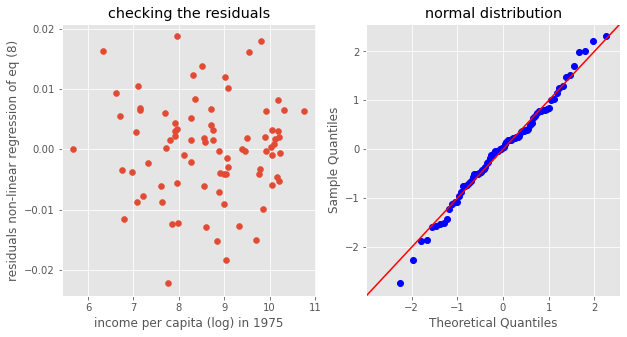

In [17]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))

ax1.scatter(x=dat.ypc0, y=estim[0].fun)
# plt.scatter(x=dat.iloc[smpl[1]]['ypc0'], y=estim[1].fun, color='blue')
# plt.scatter(x=dat.iloc[smpl[2]]['ypc0'], y=estim[2].fun, color='green')
ax1.title.set_text('checking the residuals')
ax1.set_xlabel('income per capita (log) in '+str(year0))
ax1.set_ylabel('residuals non-linear regression of eq (8)')

sm.qqplot(estim[0].fun, stats.norm, fit=True, line='45', ax = ax2)
ax2.set_title('normal distribution')

plt.show()

## Counterfactual: fixed emissions (p = 0)

In [18]:
coef    = estim[0].x    # estimated coefficients
res     = estim[0].fun  # residuals
thisdat = dat.copy()
thisdat['p'] = 0        # set p=0 in counterfactual exercise
gy_cfact = model(coef) + res
ypc1_cfact = dat['ypc0'] + gy_cfact*Dt

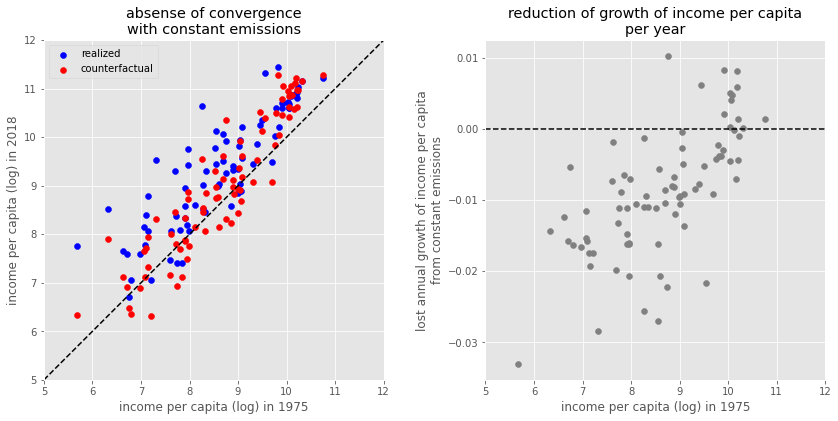

In [19]:
fig = plt.figure(figsize=[14,7])
plt.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(1, 2, 1)
ax.scatter(x=dat.ypc0 , y=dat.ypc1  , color='blue', label='realized')
ax.scatter(x=dat.ypc0 , y=ypc1_cfact, color='red' , label='counterfactual')

ax.set_title('absense of convergence\nwith constant emissions')
ax.legend(loc='upper left');
plt.xlabel('income per capita (log) in '+str(year0))
plt.ylabel('income per capita (log) in '+str(year1))

plt.xlim([5,12])
plt.ylim([5,12])
ax.plot([5,12],[5,12],'k--')
ax.set_aspect('equal')

ax = fig.add_subplot(1, 2, 2)
ax.set_title('reduction of growth of income per capita\nper year')
ax.scatter(x=dat.ypc0 , y=gy_cfact-dat.gy, color='grey')

plt.xlabel('income per capita (log) in '+str(year0))
plt.ylabel('lost annual growth of income per capita\nfrom constant emissions')

plt.xlim([5,12])
ax.plot([5,12],[0,0],'k--')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

plt.show()